# 2.0 NLP

## Foundations of Spatial Data Science - CASA0013

### Group Project - Policy Brief

### 2.1 Set Up

In [42]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [6]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

In [9]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [ ]:
#Configure
#nltk.download('wordnet') # <-- These are done in a supporting tool, but in your own
#nltk.download('averaged_perceptron_tagger') # application you'd need to import them
stopword_list = set(stopwords.words('english'))

In [10]:
#Function to output Markdown

from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

### 2.2 Reading In

In [44]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [64]:
# Reading in listings data
listings = gpd.read_feather(("data/2022-09-10-listings.geofeather"), columns= ['index', 'geometry', 'id', 'listing_url', 'name', 
                               'description', 'amenities', 'price']).set_index('id')
listings.shape

(68741, 7)

In [65]:
# Read in London boundaries
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/Boroughs.gpkg locally!
Found data/Water.gpkg locally!
Found data/Greenspace.gpkg locally!
Done.


In [18]:
print(f"gdf has {listings.shape[0]:,} rows.")

gdf has 68,741 rows.


In [66]:
listings = listings.to_crs('epsg:27700')

### 2.3 Remove NaN Values

In [72]:
listings = listings.dropna(subset=['description','amenities'])
print(f"Now gdf has {listings.shape[0]:,} rows.")

Now gdf has 67,475 rows.


### 2.4 Description Field

In [81]:
listings.description.sample(5, random_state=42)

id
699053507371704448                                                                                                                                                                                                                                        Recently refurbished.
53382856              ✪ MARCH BOOKINGS - DISCOUNTED RATES ✪<br /><br />★ JB Stays Serviced Accommodation Wimbledon☎<br /><br />☛ 1 Bed Apartment<br />❅  Sleeps Up to 2 Guests<br />☛ Common space – 1 Sofa bed<br />❅  Free WiFi <br />☛ Fully Equipped Kitchen<br />❅  A s...
21068222              Beautiful, newly redecorated period house, with genuine Edwardian touches and styling. Bright and airy, lots of light, secret lush garden. Direct sunlight travels around the house all day long. The property benefits from a spacious kitchen with d...
25912554              Welcome to Applecourt, a lovely self-contained cedar-clad cabin with its own private drive and courtyard.<br /><br />Located just 1 minute away from the A3 on 

### 2.5 Creating RegEx

In [36]:
#Increase column width
print(f"Default maximum column width: {pd.options.display.max_colwidth}") # What's this currently set to?
pd.options.display.max_colwidth=250   

Default maximum column width: 250


In [105]:
#Cultural REGEX
# clt_listings = listings[listings.description.str.contains(r'vibrant|young|exciting|nightlife|night life|art', regex=True, flags=re.IGNORECASE)].copy()

clt_listings = listings[listings.description.str.contains(r'theatre|dance|night clubs| music venue', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {clt_listings.shape[0]:,} records for 'cultural' listings")

Found 2,375 records for 'cultural' listings


Almost all listings have the word culture/cutural in its description

In [59]:
listings.shape[0]

67475

### 2.5.1 Plot clt_listings

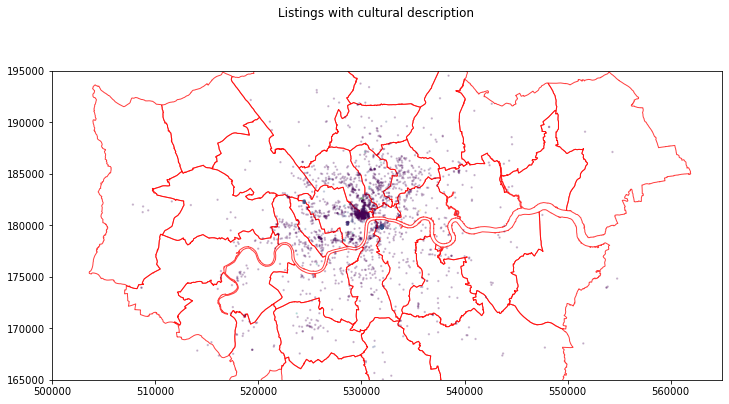

In [103]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# Map
ax1 = plt.subplot2grid((4,1), (0,0), rowspan= 3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
clt_listings.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# # Histogram
# ax2 = plt.subplot2grid((4,1), (3,0), rowspan= 1)
# clt_listings.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings with cultural description") # <-- How does this differ from title? Change it and see!
# plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
plt.show()